In [1253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from matplotlib import colormaps
import matplotlib.colors as color
import re

<h2>Загрузка и первичная очистка данных</h2>

Масса Земли в массах Юпитера

In [1254]:
JUP_MASS_EARTH = 316.8

Радиус Земли в радиусах Юпитера

In [1255]:
JUP_RAD_EARTH = 11.2

Функции преобразования масс и радиусов в Юпитерах в логарифмы масс и радиусов в Землях

In [1256]:
calc_log_e_ms = lambda x: np.log10(x * JUP_MASS_EARTH)
calc_log_e_rd = lambda x: np.log10(x * JUP_RAD_EARTH)

Преобразование масс и радиусов из датасета

In [1257]:
def get_log_mass(df):
    return df["mass"].map(calc_log_e_ms).to_list()

def get_log_rad(df):
    return df["radius"].map(calc_log_e_rd).to_list()

Функция отображения данных по осям логарифма радиуса в Землях и логарифма массы в Землях

In [1258]:
def show_mass_radius_plot(df, title):
    mass = get_log_mass(df)
    radius = get_log_rad(df)

    fig, axes = plot.subplots()

    axes.scatter(mass, radius, s=2, alpha=0.4)

    axes.set_title(title)

    axes.set_xlabel("log(Масса, масс Земли)")
    axes.set_ylabel("log(Радиус, рад. Земли)")

    axes.set_xlim(-2, 5)
    axes.set_ylim(-1, 2)

    plot.show()

Загрузка данных и выбор колонок

In [1259]:
cols = [
    "name", 
    "mass", 
    "mass_error_min", 
    "mass_error_max",
    "radius",
    "radius_error_min",
    "radius_error_max",
    "orbital_period",
    "orbital_period_error_min",
    "orbital_period_error_max",
    "semi_major_axis",
    "semi_major_axis_error_min",
    "semi_major_axis_error_max",
    "eccentricity",
    "eccentricity_error_min",
    "eccentricity_error_max",
    "temp_calculated",
    "temp_calculated_error_min",
    "temp_calculated_error_max",
    "star_name",
    "mag_v",
    "star_distance",
    "star_distance_error_min",
    "star_distance_error_max",
    "star_sp_type",
    "star_metallicity",
    "star_metallicity_error_min",
    "star_metallicity_error_max",
    "star_mass",
    "star_mass_error_min",
    "star_mass_error_max",
    "star_radius",
    "star_radius_error_min",
    "star_radius_error_max",
    "star_teff",
    "star_teff_error_min",
    "star_teff_error_max",
]
exo_df = pd.read_csv("f0hslSOZ.csv")[cols]


Выбор объектов, которые являются компаньонами звезд

In [1260]:
exo_only_comp = exo_df.query("star_name.notna()")

Выбор объектов, для которых измерены и масса и радиус

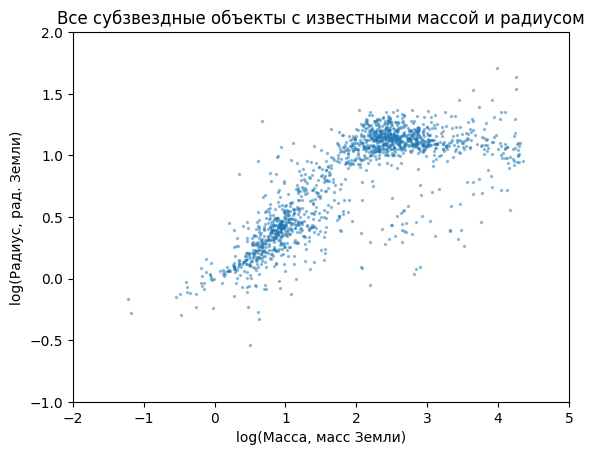

In [1261]:
exo_mass_rad = exo_only_comp.query("mass.notna() and radius.notna()")

show_mass_radius_plot(exo_mass_rad, "Все субзвездные объекты с известными массой и радиусом")

Выбор объектов, с точно измеренными массой и радиусом

Выбираются объекты, относительная погрешность которых не превышает MAX_REL_ERR

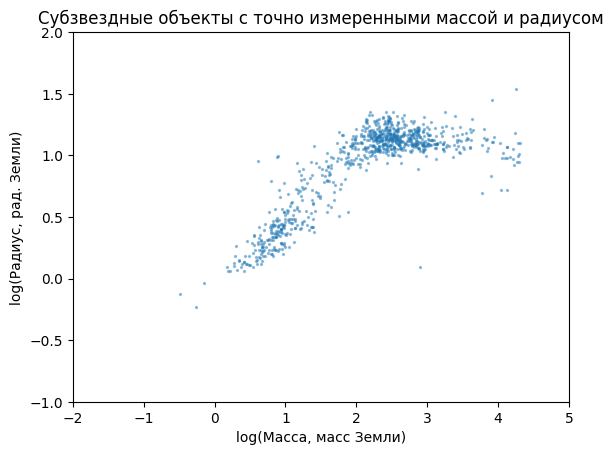

In [1262]:
MAX_REL_ERR = 0.2

precise_q = "(mass_error_min + mass_error_max) / 2 < mass * {rel_err} and (radius_error_min + radius_error_max) / 2 < radius * {rel_err}".format(rel_err=MAX_REL_ERR)
exo_precise = exo_mass_rad.query(precise_q)

show_mass_radius_plot(exo_precise, "Субзвездные объекты с точно измеренными массой и радиусом")

Выбор объектов планетарной массы

Объектами планетарной массы будем считать те объекты, масса которых не превышает MAX_PL_MASS_JUP масс ЮПИТЕРА

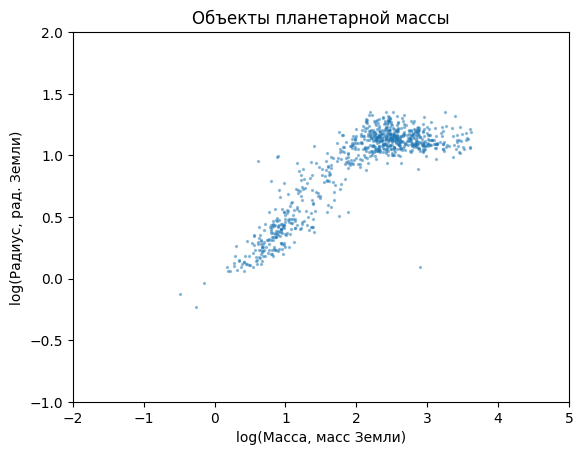

In [1263]:
MAX_PL_MASS_JUP = 13

only_planets_q = "mass < {mass}".format(mass=MAX_PL_MASS_JUP)
exo_only_planets = exo_precise.query(only_planets_q)

show_mass_radius_plot(exo_only_planets, "Объекты планетарной массы")

Сохраняем предварительно отфильтрованные данные в файл

In [1264]:
exo_only_planets.to_csv("exo_filtered.csv")

<h2>Расчет недостающих данных</h2>

Радиус Солнца в км

In [1265]:
SOL_RAD_KM =  6.957e+5

Масса Солнца в кг

In [1266]:
SOL_MASS_KG = 1.989e+30

Астрономическая единица в км

In [1267]:
AE_KM = 1.496e+8

Гравитационная постоянная и ее ошибка

In [1268]:
G = 6.6743e-11
G_RERR = 5e-5

In [1269]:
exo_teff_df = exo_only_planets

In [1270]:
def get_err_abs(err):
    try:
        err_parsed = float(err)
        err_abs = abs(err_parsed)

        return err_abs

    except ValueError:
        return err

In [1271]:
errors = exo_teff_df.filter(regex="error_m(in|ax)", axis=1)
errors_abs = exo_teff_df.apply(lambda s: s.apply(get_err_abs))
exo_teff_df.update(errors_abs)

exo_teff_df.to_csv("exo_with_teff.csv")

In [1272]:
def get_order(val):
    order = int(-np.floor(np.log10(val)))
    
    return order

def to_prec(val, prec):
    val_ord = get_order(val)
    val_prec = np.round(val, val_ord + prec - 1)

    return val_prec

def normalize(n):
        digits = get_order(n)
        n_norm = n * 10 ** digits

        return n_norm

def round_err(err):
    if pd.isna(err):
        return pd.NA
    
    if np.isinf(err):
        return np.inf

    if err == 0:
        return 0

    err_d1 = to_prec(err, 1)
    err_d2 = to_prec(err, 2)

    if normalize(err_d1) <= 2:
        return err_d2
    
    else:
        return err_d1
    
def round_val(val, err):
    if pd.isna(val):
        return pd.NA
    
    if np.isinf(val):
        return np.inf

    if val == 0:
        return 0
    
    if pd.isna(err) or np.isinf(err) or err == 0:
        return val
    
    abs_val = abs(val)

    err_ord = get_order(err)
    abs_val_round = to_prec(abs_val, err_ord + 1)

    if val < 0:
        val_round = -abs_val_round

    else:
        val_round = abs_val_round

    return val_round

In [1273]:
def calc_err(val):
    val_str = str(val)

    try:
        dot_pos = val_str.rindex('.')

    except ValueError:
        dot_pos = 0

    if dot_pos > 0:
        err = 10 ** (dot_pos - len(val_str) + 1)
        return err
    
    try:
        last_zero_pos = val_str.rindex('0')

    except ValueError:
        last_zero_pos = 0

    if last_zero_pos != len(val_str) - 1:
        return 1
    
    for i in reversed(range(len(val_str))):
        if val_str != 0:
            err = 10 ** (len(val_str) - i)
            return err    

def get_err(val):
    if pd.notna(val) and val != 0:
        err = calc_err(val)

        return err
    
    else:
        return pd.NA

In [1274]:
exo_teff_df["orbital_period_error_min"] = exo_teff_df["orbital_period_error_min"].fillna(
    exo_teff_df["orbital_period"].apply(get_err)
)

exo_teff_df["orbital_period_error_max"] = exo_teff_df["orbital_period_error_max"].fillna(
    exo_teff_df["orbital_period"].apply(get_err),
)

exo_teff_df["star_mass_error_min"] = exo_teff_df["star_mass_error_min"].fillna(
    exo_teff_df["orbital_period"].apply(get_err)
)

exo_teff_df["star_mass_error_max"] = exo_teff_df["star_mass_error_max"].fillna(
    exo_teff_df["orbital_period"].apply(get_err)
)

exo_teff_df.to_csv("exo_with_teff.csv")

C:\Users\Kochoba\AppData\Local\Temp\ipykernel_3872\3157815978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_teff_df["orbital_period_error_min"] = exo_teff_df["orbital_period_error_min"].fillna(
C:\Users\Kochoba\AppData\Local\Temp\ipykernel_3872\3157815978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exo_teff_df["orbital_period_error_max"] = exo_teff_df["orbital_period_error_max"].fillna(


In [1275]:
def calc_sm_axis(star_mass, period):
    period_s = period * 24 * 60 * 60
    star_mass_kg = star_mass * SOL_MASS_KG

    sm_axis_km = np.power((G * star_mass_kg * period_s ** 2) / (4 * np.pi ** 2), 1 / 3)
    sm_axis = sm_axis_km / (AE_KM * 1000)

    return sm_axis.item()

def get_sm_axis(star_mass, period):
    if pd.notna(star_mass) and pd.notna(period):
        sm_axis = calc_sm_axis(star_mass, period)

        return sm_axis

    else:
        return pd.NA

In [1276]:
def calc_sm_axis_err(sm_axis, star_mass, star_mass_err, period, period_err):
    star_mass_rerr = star_mass_err / star_mass
    period_rerr = period_err / period
    
    sm_axis_rerr = (G_RERR + star_mass_rerr + 2 * period_rerr) / 3
    
    err = sm_axis_rerr * sm_axis

    err_round = round_err(err)
    
    return err_round

def get_sm_axis_err(sm_axis, star_mass, star_mass_err, period, period_err):
    if all(
        map(pd.notna, [sm_axis, star_mass, star_mass_err, period, period_err])
    ):
        sm_axis_err = calc_sm_axis_err(sm_axis, star_mass, star_mass_err, period, period_err)
        sm_axis_err_r = round_err(sm_axis_err)

        return sm_axis_err_r

    else:
        return pd.NA

In [1277]:
exo_teff_df = exo_teff_df.fillna(
    value={
        "semi_major_axis": exo_teff_df.apply(
            lambda r: get_sm_axis(
                r["star_mass"],
                r["orbital_period"],
            ),
            axis=1
        )
    }
)

exo_teff_df = exo_teff_df.fillna(
    value={
        "semi_major_axis_error_min": exo_teff_df.apply(
            lambda r: get_sm_axis_err(
                r["semi_major_axis"],
                r["star_mass"],
                r["star_mass_error_min"],
                r["orbital_period"],
                r["orbital_period_error_min"],
            ),
            axis=1
        )
    }
)

exo_teff_df = exo_teff_df.fillna(
    value={
        "semi_major_axis_error_max": exo_teff_df.apply(
            lambda r: get_sm_axis_err(
                r["semi_major_axis"],
                r["star_mass"],
                r["star_mass_error_max"],
                r["orbital_period"],
                r["orbital_period_error_max"],
            ),
            axis=1
        )
    }
)

exo_teff_df["semi_major_axis"] = exo_teff_df.apply(
    lambda s: round_val(s["semi_major_axis"], s["semi_major_axis_error_max"]),
    axis=1
)

exo_teff_df.to_csv("exo_with_teff.csv")

Какую дефолтную величину альбедо использовать при расчетах эффективной температуры

In [1278]:
ALB = 0

Расчет средней эффективной температуры, максимальной эффективной температуры, минимальной эффективной температуры

In [1279]:
def calc_teff(star_teff, star_rad, dist, alb):
    star_rad_m = star_rad * SOL_RAD_KM
    dist_m = dist * AE_KM

    teff = star_teff * np.sqrt(star_rad_m / (2 * dist_m)) * np.power(1 - alb, 0.25)
        
    return teff  

def get_teff(star_teff, star_rad, dist, alb):
    if all(
        map(pd.notna, [star_teff, star_rad, dist])
    ):
        teff = calc_teff(star_teff, star_rad, dist, alb)

        return teff

    else:
        return pd.NA

def calc_teff_max(star_teff, star_rad, sm_axis, ecc, alb):
    min_dist = sm_axis * (1 - ecc)

    teff = calc_teff(star_teff, star_rad, min_dist, alb)
    return teff

def calc_teff_min(star_teff, star_rad, sm_axis, ecc, alb):
    max_dist = sm_axis * (1 + ecc)

    teff = calc_teff(star_teff, star_rad, max_dist, alb)
    return teff

In [1280]:
def calc_mean_teff_error(teff, star_teff, star_teff_err, star_rad, star_rad_err, sm_axis, sm_axis_err):
    star_teff_rerr = star_teff_err / star_teff
    star_rad_rerr = star_rad_err / star_rad
    sm_axis_rerr = sm_axis_err / sm_axis
        
    teff_rerr = star_teff_rerr + (star_rad_rerr + sm_axis_rerr) / 2

    err = teff * teff_rerr

    err_round = round_err(err)

    return err_round

def calc_min_max_teff_error(teff, star_teff, star_teff_err, star_rad, star_rad_err, sm_axis, sm_axis_err, ecc=0, ecc_err=0, minmax="min"):
    star_teff_rerr = star_teff_err / star_teff
    star_rad_rerr = star_rad_err / star_rad
    sm_axis_rerr = sm_axis_err / sm_axis

    if minmax == "min":
        ecc_rerr = ecc_err / (1 + ecc)
    
    elif minmax == "max":
        ecc_rerr = ecc_err / (1 - ecc)

    else:
        raise ValueError("A minmax argument value can only has \"min\" or \"max\" value")
        
    teff_rerr = star_teff_rerr + (star_rad_rerr + sm_axis_rerr + ecc_rerr) / 2

    err = teff * teff_rerr

    err_round = round_err(err)

    return err_round


In [1281]:
BG_COLOR = "0.15"
PLOT_BG_COLOR = "0.18"
T_TITLE_COLOR = "white"
T_COLOR = "0.8"

In [1282]:
exo_teff_df.loc[:, "planet_teff_mean"] = exo_teff_df.apply(
    lambda row: calc_teff(
        row["star_teff"],
        row["star_radius"],
        row["semi_major_axis"],
        ALB
    ),
    axis=1
)
exo_teff_df.loc[:, "planet_teff_mean_error_min"] = exo_teff_df.apply(
    lambda row: calc_mean_teff_error(
        row["planet_teff_mean"],
        row["star_teff"],
        row["star_teff_error_min"],
        row["star_radius"],
        row["star_radius_error_min"],
        row["semi_major_axis"],
        row["semi_major_axis_error_min"]
    ),
    axis=1
)
exo_teff_df.loc[:, "planet_teff_mean_error_max"] = exo_teff_df.apply(
    lambda row: calc_mean_teff_error(
        row["planet_teff_mean"],
        row["star_teff"],
        row["star_teff_error_max"],
        row["star_radius"],
        row["star_radius_error_max"],
        row["semi_major_axis"],
        row["semi_major_axis_error_max"]
    ),
    axis=1
)
exo_teff_df.loc[:, "planet_teff_mean"] = round_val(
    exo_teff_df["planet_teff_mean"],
    exo_teff_df["planet_teff_mean_error_max"]
)

exo_teff_df.loc[:, "planet_teff_min"] = calc_teff_min(
    exo_teff_df["star_teff"], 
    exo_teff_df["star_radius"],
    exo_teff_df["semi_major_axis"],
    exo_teff_df["eccentricity"],
    ALB
)
exo_teff_df.loc[:, "planet_teff_min_error_min"] = calc_min_max_teff_error(
    exo_teff_df["planet_teff_min"],
    exo_teff_df["star_teff"],
    exo_teff_df["star_teff_error_min"],
    exo_teff_df["star_radius"],
    exo_teff_df["star_radius_error_min"],
    exo_teff_df["semi_major_axis"],
    exo_teff_df["semi_major_axis_error_min"],
    exo_teff_df["eccentricity"],
    exo_teff_df["eccentricity_error_min"],
    minmax="min"
)
exo_teff_df.loc[:, "planet_teff_min_error_max"] = calc_min_max_teff_error(
    exo_teff_df["planet_teff_min"],
    exo_teff_df["star_teff"],
    exo_teff_df["star_teff_error_max"],
    exo_teff_df["star_radius"],
    exo_teff_df["star_radius_error_max"],
    exo_teff_df["semi_major_axis"],
    exo_teff_df["semi_major_axis_error_max"],
    exo_teff_df["eccentricity"],
    exo_teff_df["eccentricity_error_max"],
    minmax="min"
)
exo_teff_df.loc[:, "planet_teff_min"] = round_val(
    exo_teff_df["planet_teff_min"],
    exo_teff_df["planet_teff_min_error_max"]
)

exo_teff_df.loc[:, "planet_teff_max"] = calc_teff_max(
    exo_teff_df["star_teff"], 
    exo_teff_df["star_radius"],
    exo_teff_df["semi_major_axis"],
    exo_teff_df["eccentricity"],
    ALB
)
exo_teff_df.loc[:, "planet_teff_max_error_min"] = calc_min_max_teff_error(
    exo_teff_df["planet_teff_max"],
    exo_teff_df["star_teff"],
    exo_teff_df["star_teff_error_min"],
    exo_teff_df["star_radius"],
    exo_teff_df["star_radius_error_min"],
    exo_teff_df["semi_major_axis"],
    exo_teff_df["semi_major_axis_error_min"],
    exo_teff_df["eccentricity"],
    exo_teff_df["eccentricity_error_min"],
    minmax="max"
)
exo_teff_df.loc[:, "planet_teff_max_error_max"] = calc_min_max_teff_error(
    exo_teff_df["planet_teff_max"],
    exo_teff_df["star_teff"],
    exo_teff_df["star_teff_error_max"],
    exo_teff_df["star_radius"],
    exo_teff_df["star_radius_error_max"],
    exo_teff_df["semi_major_axis"],
    exo_teff_df["semi_major_axis_error_max"],
    exo_teff_df["eccentricity"],
    exo_teff_df["eccentricity_error_max"],
    minmax="max"
)
exo_teff_df.loc[:, "planet_teff_max"] = round_val(
    exo_teff_df["planet_teff_max"],
    exo_teff_df["planet_teff_max_error_max"]
)

C:\Users\Kochoba\AppData\Local\Temp\ipykernel_3872\3062218134.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  sm_axis_rerr = sm_axis_err / sm_axis
C:\Users\Kochoba\AppData\Local\Temp\ipykernel_3872\3062218134.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  sm_axis_rerr = sm_axis_err / sm_axis


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

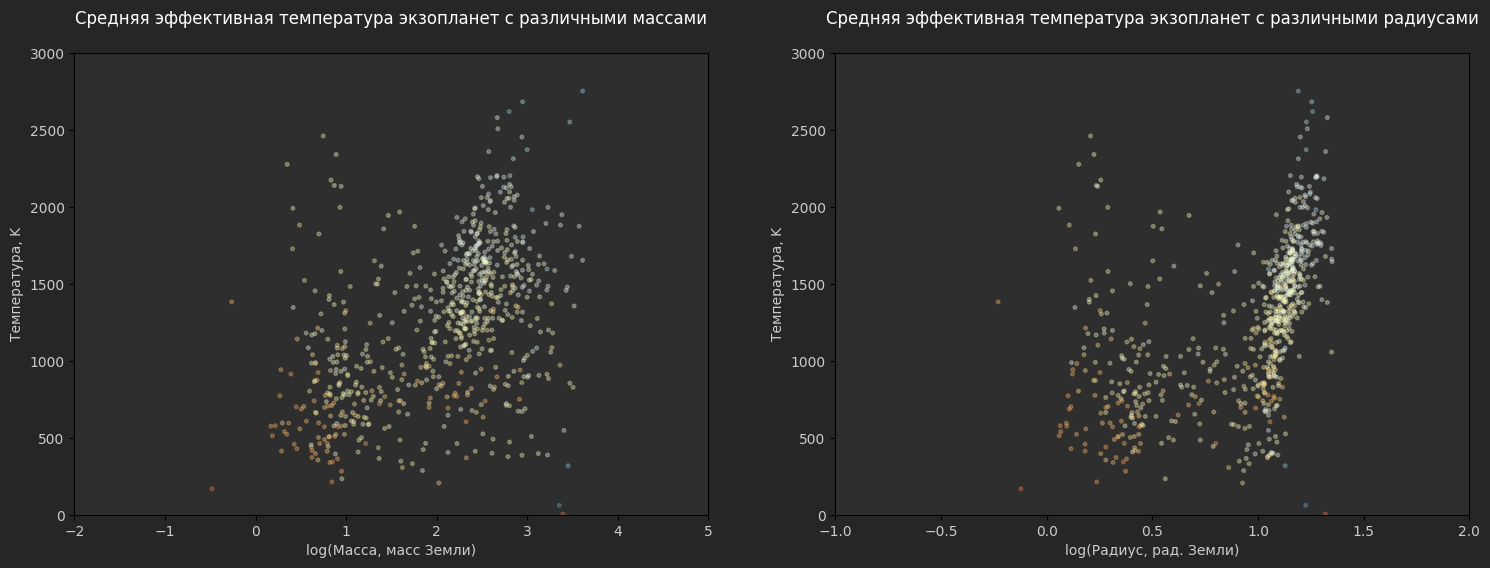

In [ ]:
mean_teff = exo_teff_df.get("planet_teff_mean").tolist()
star_teff = exo_only_planets.get("star_teff").tolist()
mass = get_log_mass(exo_only_planets)
radius = get_log_rad(exo_only_planets)

fig, axes = plot.subplots(facecolor=BG_COLOR, ncols=2)

fig.set_figwidth(18)
fig.set_figheight(6)

colormap = colormaps.get_cmap("RdYlBu")
norm = color.Normalize(0, 11000)

axes[0].scatter(mass, mean_teff, s=7, alpha=0.33, color=colormap(norm(star_teff)))
axes[1].scatter(radius, mean_teff, s=7, alpha=0.33, color=colormap(norm(star_teff)))

for a in axes:
    a.set_facecolor(PLOT_BG_COLOR)

    a.set_ylabel("Температура, K", color=T_COLOR)
    a.set_ylim(0, 3000)
    a.set_yticks(np.arange(0, 3500, 500))

    a.tick_params(labelcolor=T_COLOR)

axes[0].set_title("Cредняя эффективная температура экзопланет с различными массами\n", color=T_TITLE_COLOR)
axes[0].set_xlabel("log(Масса, масс Земли)", color=T_COLOR)
axes[0].set_xlim(-2, 5)

axes[1].set_title("Cредняя эффективная температура экзопланет с различными радиусами\n", color=T_TITLE_COLOR)
axes[1].set_xlabel("log(Радиус, рад. Земли)", color=T_COLOR)
axes[1].set_xlim(-1, 2)

plot.show()

In [ ]:
exo_teff_df.to_csv("exo_with_teff.csv")